# DAT-NYC-37 | Codealong and Lab 15 | Natural Language Processing and Text Classification

# Codealong - Text Processing with `sklearn`

In [29]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, ensemble, cross_validation, metrics

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

The data is about sentiments on Amazon reviews.

In [30]:
reviews = []
sentiments = []

with open(os.path.join('..', 'datasets', 'amazon-reviews.txt')) as f:
    for line in f.readlines():
        line = line.strip('\n')
        review, sentiment = line.split('\t')
        sentiment = np.nan if sentiment == '' else int(sentiment)

        reviews.append(review)
        sentiments.append(sentiment)

df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [31]:
df.head()

,review,sentiment
0,I try not to adjust the volume setting to avoi...,NaN
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
3,I thought Motorola made reliable products!.,NaN
4,Battery for Motorola Razr.,NaN


In [32]:
df.dropna(inplace = True) # Let's drop NaNs

In [33]:
df.head()

,review,sentiment
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
5,Great for the jawbone.,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great.,1.0


In [34]:
X = df.review
y = df.sentiment

## Train/test sets

In [35]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

In [36]:
train_X

1343    every thing on phone work perfectly, she like it.
896                         Comfort for our whole family.
2162                                  Just what I wanted.
1123    A PIECE OF JUNK THAT BROKE AFTER BEING ON MY P...
1999    Much less than the jawbone I was going to repl...
                              ...                        
2139    .... Item arrived quickly and works great with...
1579    This frog phone charm is adorable and very eye...
1084                    Rip off---- Over charge shipping.
2064    Appears to actually outperform the original ba...
815              I love all the features and form factor.
Name: review, dtype: object

## `CountVectorizer`

`CountVectorizer` converts a collection of text into a matrix of features.  Each row will be a sample (an article or piece of text) and each column will be a text feature (usually a count or binary feature per word).

**`CountVectorizer` takes a column of text and creates a new dataset.**  It generates a feature for every word in all of the pieces of text.

CAUTION: Using all of the words can be useful, but we may need to use regularization to avoid overfitting.  Otherwise, rare words may cause the model to overfit and not generalize.

(And check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html as needed)

In [37]:
# Instantiate a new CountVectorizer

# Stopwords are non-content words.  (e.g. 'to', 'the', and 'it')
# They aren’t helpful for prediction, so we remove them.
# We'll almost always want to specify `stop_words = 'english'` to exclude stop words
vectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english')

In [38]:
vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Vectorizers are like other models in `sklearn`:
- We create a vectorizer object with the parameters of our feature space
- We fit a vectorizer to learn the vocabulary
- We transform a set of text into that feature space

Note: there is a distinction between fit and transform:
- We fit from our training set.  This is part of the model building process, so we don't look at our test set
- We transform our test set using our model fit on the training set

In [39]:
# We use `fit` to learn the vocabulary of the reviews

vectorizer.fit(train_X)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [40]:
# The bag-of-words

vectorizer.get_feature_names()

[u'10',
 u'100',
 u'11',
 u'12',
 u'15g',
 u'20',
 u'2160',
 u'24',
 u'2mp',
 u'325',
 u'350',
 u'375',
 u'42',
 u'44',
 u'45',
 u'4s',
 u'5020',
 u'5320',
 u'680',
 u'700w',
 u'8125',
 u'8525',
 u'ability',
 u'able',
 u'absolutely',
 u'ac',
 u'accept',
 u'access',
 u'accessing',
 u'accessory',
 u'accidentally',
 u'accompanied',
 u'according',
 u'activate',
 u'actually',
 u'ad',
 u'adapter',
 u'adapters',
 u'add',
 u'addition',
 u'adhesive',
 u'adorable',
 u'advertised',
 u'advise',
 u'aggravating',
 u'ago',
 u'alarm',
 u'allot',
 u'allow',
 u'allowing',
 u'allows',
 u'alot',
 u'aluminum',
 u'amazed',
 u'amazon',
 u'amp',
 u'answer',
 u'ant',
 u'anti',
 u'apart',
 u'apartment',
 u'apparently',
 u'appearance',
 u'appears',
 u'applifies',
 u'area',
 u'armband',
 u'arrival',
 u'arrived',
 u'asia',
 u'ask',
 u'aspect',
 u'att',
 u'attractive',
 u'audio',
 u'auto',
 u'available',
 u'avoid',
 u'avoiding',
 u'away',
 u'awesome',
 u'awful',
 u'background',
 u'backlight',
 u'bad',
 u'barely',
 

In [41]:
# We use `transform` to generate the sample X word matrix - one column per feature (here, a word)

train_X_transformed = vectorizer.transform(train_X)
test_X_transformed = vectorizer.transform(test_X)

In [42]:
train_X_transformed

<600x1168 sparse matrix of type '<type 'numpy.int64'>'
	with 2861 stored elements in Compressed Sparse Row format>

While dense matrices store every entry in the matrix, sparse matrices only store the nonzero entries.  Sparse matrices don't have a lot of extra features, and some algorithms may not work for them so you use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily.  You can convert from sparse matrices to dense matrices with `.todense()`

In [43]:
train_X_transformed.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [44]:
# Q: What are the 10 most commonly used words in our training set?

## Random Forest

We can now build a random forest model to predict "sentiment".

In [45]:
# Review Q: Why might we use a Random Forest model here instead of a decision tree?

In [46]:
rf_model = ensemble.RandomForestClassifier(n_estimators = 10)

cross_validation.cross_val_score(rf_model, train_X_transformed, train_y, cv=5, scoring = 'roc_auc')

array([ 0.82896175,  0.86968602,  0.77063073,  0.85190331,  0.89548023])

In [47]:
# Q: *In your own words*, describe what `cross_val_score` is doing:

In [48]:
rf_model.fit(train_X_transformed, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
rf_model.score(train_X_transformed, train_y)

0.97999999999999998

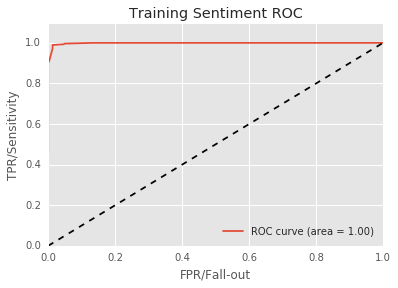

In [50]:
train_y_hat = rf_model.predict_proba(train_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_hat[:, 1])

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Training Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

import seaborn as sns

# plt.figure()
# sns.distplot(fpr, color="red", bins=10)
# sns.distplot(tpr, color="green", bins=10);

In [51]:
rf_model.score(test_X_transformed, test_y);

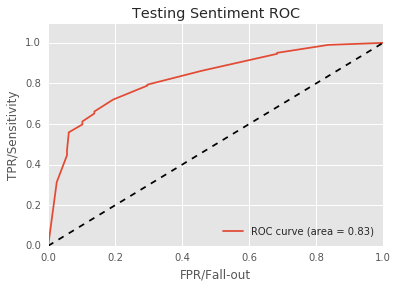

In [52]:
test_y_hat = rf_model.predict_proba(test_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(test_y, test_y_hat[:, 1])

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Testing Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

# plt.figure();

# sns.distplot(fpr, color="red", bins=10);
# sns.distplot(tpr, color="blue", bins=10);

# Lab - TF-IDF

Directions: Redo the analysis above with `TfidfVectorizer` instead of `CountVectorizer`. Use 10 estimators for your Random Forest Classifier.  What results do you get?

(Check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html as needed)

In [53]:
# TODO: Analysis here:


In [54]:
# Q: What words have the highest Tf-Idf? What does this indicate?

## Bonus Questions/Exercises:

- Which features are most important? (hint: Read the docs: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- Use `cross_val_score` instead of a simple train/test split. How much does your model improve?
- In your own words*, describe what `cross_val_score` is doing
- Try including larger n_grams (e.g. 2 or 3) in your analysis. Does this improve your results?
- Why might using KNN be a bad idea on this dataset?